# Day 1: The Color Bach

This is an experiment that uses the Spotify Web API to compute the average colors used in classical music album covers and generate a sample cover for that composer. Connecting to Spotify was a breeze with `spotipy`, and downloading and saving the cover images was OK with `urllib`, but it's pretty slow. Needs more concurrency. `spotipy` checks environment variables for authentication keys, which can be requested at dev.spotify.com. I don't bother filtering Spotify query results, so this works with any search query, not just composer names.

As for extracting the color palettes from the downloaded images, I first found the library `colorweave`, which was a total pain to use because it required an older version of `pillow` (a fork of `PIL`, the Python Imaging Library) because of a broken call to `pillow`'s api. The more impressive - but scantily documented - `colorific` (by [99 designs](https://github.com/99designs/colorific)) also had a dependency on `pillow`, and is not really advertised as a module (but is importable as such) and worked well, eventually.

I kept getting stuck with an `IOError: jpeg decoder not installed` from `pillow`, and it took close to an hour to come up with a solution. I'm on 64-bit Linux, FWIW. And, since I was (trying) to use a virtualenv for this project, I'm not sure what of this solution actually worked; I think I fell back on installing to the system dist-packages location with the ill-advised `sudo pip install`... At this point, I can't remember. Dependencies can be a bit of a nightmare when starting out.

1. Uninstall `pillow` and `PIL` with PIP
2. Install `libjpeg8-dev` headers with your package manager of choice
3. Download and extract latest `pillow` source somewhere
4. Make a symlink or too per this SO response: http://stackoverflow.com/a/12301138
5. `(sudo) python setup.py` in the root directory of the `pillow` source

Initially I found the average of a bunch of colors in RGB space but points close in this space are not necessarily perceptually similar, so I use a module called `colormath` to convert in to the so-called Lab colorspace, do the math, and pop back into RGB. Probably could use something clever like clustering.

Results in the last cell.

In [1]:
import spotipy
import colorific
import urllib
import PIL

from colormath.color_objects import XYZColor, sRGBColor, LabColor
from colormath.color_conversions import convert_color

from IPython.display import HTML, display
from IPython.display import Image as ShowImage
from glob import glob
from spotipy.oauth2 import SpotifyClientCredentials
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

In [2]:
# Initialize spotipy service

client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
def calculate_perceptual_average(colorlist):
    lablist = []
    
    for color in colorlist:
        rgb = sRGBColor(*color)
        xyz = convert_color(rgb, XYZColor, target_illuminant='d50')
        lab = convert_color(xyz, LabColor)
        lablist.append(lab.get_value_tuple())
    
    # First implementation had this, computing average in RGB space
    # naive_average = tuple(map(lambda y: int(sum(y) / float(len(y))), zip(*colorlist)))
    
    average = tuple(map(lambda y: int(sum(y) / float(len(y))), zip(*lablist)))
    
    average_lab = LabColor(*average)
    average_xyz = convert_color(average_lab, XYZColor, target_illuminant='d50')
    average_rgb = convert_color(average_xyz, sRGBColor)
    
    return tuple(map(int, (average_rgb.get_value_tuple())))

In [4]:
def generate_album_cover(composer, n=15):
    results = sp.search(composer, limit=n, type='album')

    album_art_urls = []
    
    # The first url is the highest resolution
 
    for album in results['albums']['items']:
        album_art_urls.append(album['images'][0]['url'])
 
    # Download each of the album art images
    
    for album_art_url in album_art_urls:
        urllib.urlretrieve(album_art_url, album_art_url.split('/')[-1] + '.jpg')
    
    album_art_colors = []

    for album_art_file in album_art_urls:
        try:
            colors = colorific.extract_colors(album_art_file.split('/')[-1] + '.jpg', max_colors=3)
            album_art_colors.append(colors)
        except IOError:
            # Sometimes the CDN that hosts the images borks up and doesn't serve a valid image file.
            # Wasn't concerned with figuring out what was happening: maybe licensing/localization issue
            continue

    primary = []
    secondary = []
    background = []
    
    # Sometimes colorific doesn't recommend more than one color
    # You get a Palette object which contains several colors ranked by prominence
    # ...and, sometimes, a bgcolor property
    
    for palette in album_art_colors:
        primary.append(palette.colors[0].value)
        
        if len(palette.colors) > 1:
            secondary.append(palette.colors[1].value)
            
        if palette.bgcolor is not None:
            background.append(palette.bgcolor.value)
        else:
            background.append((0, 0, 0))
    
    # Could be made prettier with a map()
    
    primarycolor = calculate_perceptual_average(primary)
    secondarycolor = calculate_perceptual_average(secondary)
    backgroundcolor = calculate_perceptual_average(background)
    
    # A system font on Linux. Your mileage may vary.
    
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size=25)
    
    img=Image.new("RGBA", (200,200),backgroundcolor)

    draw = ImageDraw.Draw(img)
    
    draw.text((0, 0),composer,secondarycolor,font=font)
    draw.rectangle([(45, 60), (115,150)], fill=primarycolor)
        
    img.save("cover_{}.png".format(composer))

/home/eamonn/Projects/thecolorbach/venv/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/eamonn/Projects/thecolorbach/venv/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


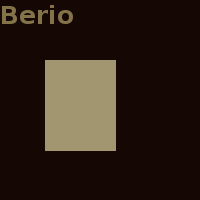

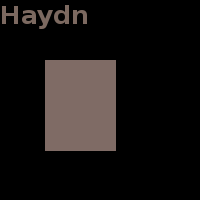

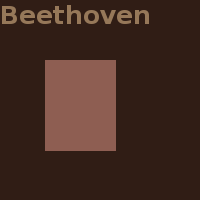

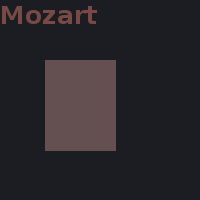

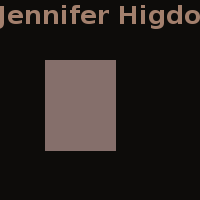

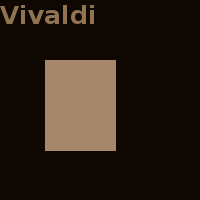

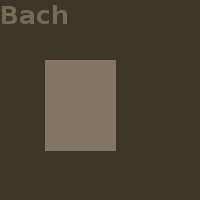

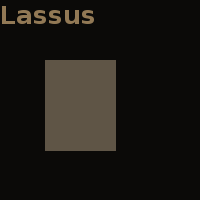

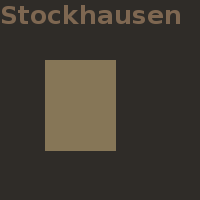

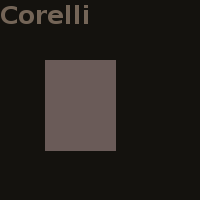

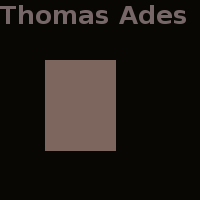

In [5]:
composers = ['Bach', 'Beethoven', 'Haydn', 'Mozart', 'Stockhausen', 'Corelli', 'Vivaldi', 'Thomas Ades', 'Lassus', 'Jennifer Higdon']

for composer in composers:
    generate_album_cover(composer)

# Uses some iPython functions to render the images in the notebook

for filename in glob("cover*.png"):
    display(ShowImage(filename=filename))